In [58]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import akshare as ak


# 股票代码集合
symbols = ["sh000001", "sh601998", "sh601398", "sh601939", "sh601288"]

# 获取数据
df = ak.stock_zh_a_daily(symbol=symbols[1], start_date="20221101", end_date="20231106")
df


,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2022-11-01,4.35,4.45,4.34,4.44,30413324.0,133772757.0,3.405268e+10,0.000893
1,2022-11-02,4.41,4.44,4.37,4.40,16669173.0,73223659.0,3.405268e+10,0.000490
2,2022-11-03,4.41,4.41,4.34,4.38,14896636.0,65011025.0,3.405268e+10,0.000437
3,2022-11-04,4.37,4.44,4.35,4.42,21083842.0,92980346.0,3.405268e+10,0.000619
4,2022-11-07,4.39,4.46,4.38,4.45,20736953.0,91741322.0,3.405268e+10,0.000609
...,...,...,...,...,...,...,...,...,...
242,2023-10-31,5.32,5.39,5.29,5.38,46904332.0,251174825.0,3.408470e+10,0.001376
243,2023-11-01,5.39,5.44,5.35,5.42,40832428.0,220567081.0,3.408470e+10,0.001198
244,2023-11-02,5.42,5.54,5.41,5.50,38047016.0,209216183.0,3.408470e+10,0.001116
245,2023-11-03,5.50,5.50,5.44,5.45,31336793.0,171207011.0,3.408470e+10,0.000919


In [32]:
'''
df1=pd.read_csv('./data/Shanghai Composite Historical Data.csv')
print(df1.columns)

df1=pd.DataFrame({
    'Date':df1.Date.values[::-1],
    'Price':[float(i.replace(',','')) for i in df1['Price'].values][::-1],
    'Open':[float(i.replace(',','')) for i in df1['Open'].values][::-1],
    'High':[float(i.replace(',','')) for i in df1['High'].values][::-1],
    'Low':[float(i.replace(',','')) for i in df1['Low'].values][::-1]
                  })
df1
'''

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


,Date,Price,Open,High,Low
0,11/01/2022,2969.20,2899.50,2969.20,2896.76
1,11/02/2022,3003.37,2960.65,3019.05,2954.95
2,11/03/2022,2997.81,2981.20,3003.72,2977.72
3,11/04/2022,3070.80,2997.00,3081.59,2997.00
4,11/07/2022,3077.82,3062.86,3088.19,3054.46
...,...,...,...,...,...
242,10/31/2023,3018.77,3019.65,3023.00,3006.61
243,11/01/2023,3023.08,3038.18,3038.33,3013.93
244,11/02/2023,3009.41,3028.66,3038.64,3009.12
245,11/03/2023,3030.80,3012.47,3040.98,3012.47


In [59]:
#Params
time_window=14
pred_window=7

BATCH_SIZE=16
nums_layer=1
lr=5e-4
test_size=0.2
N_epoch=100
device = torch.device('mps')

Price_data2=df['close'].values.reshape(-1,1)

scaler1=MinMaxScaler()
Price_data=scaler1.fit_transform(Price_data2).reshape(-1)
print(Price_data.shape)

data_his=[]
data_pred=[]
for i in range(len(Price_data)-time_window-pred_window):
    data_his.append(np.array(Price_data[i:i+time_window]))
    data_pred.append(np.array(Price_data[i+time_window:i+time_window+pred_window]))

print(data_his[0],data_pred[0])
print(len(data_his),len(data_pred))

(247,)
[0.01690141 0.0056338  0.         0.01126761 0.01971831 0.02253521
 0.01690141 0.02816901 0.05915493 0.09295775 0.08450704 0.07323944
 0.06478873 0.05352113] [0.05633803 0.10422535 0.15774648 0.15211268 0.18873239 0.13521127
 0.21408451]
226 226


In [60]:
data_his=np.array(data_his)
data_pred=np.array(data_pred)



print(data_his.shape,data_pred.shape)

Train_x,Train_y=data_his[:-int(test_size*len(data_his))],data_pred[:-int(test_size*len(data_his))]
Test_x,Test_y=data_his[-int(test_size*len(data_his)):],data_pred[-int(test_size*len(data_his)):]
print(Train_x.shape,Train_y.shape,Test_x.shape,Test_y.shape)

class TimeDataset(Dataset):
    def __init__(self,df_x,df_y):
        self.data=df_x
        self.label=df_y
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        data_value=torch.FloatTensor(self.data[index,:])
        label_value=torch.FloatTensor([self.label[index]])
        return data_value,label_value.view(-1)

train_dataset=TimeDataset(df_x=Train_x,df_y=Train_y)
valid_dataset=TimeDataset(df_x=Test_x,df_y=Test_y)
train_iterator=DataLoader(train_dataset,batch_size=BATCH_SIZE)
valid_iterator=DataLoader(valid_dataset,batch_size=BATCH_SIZE)
#test
for (data,label) in train_iterator:
    print(data.shape)
    print(label.shape)
    break


(226, 14) (226, 7)
(181, 14) (181, 7) (45, 14) (45, 7)
torch.Size([16, 14])
torch.Size([16, 7])


In [61]:
class FCN(nn.Module):
    def __init__(self,InputDim=14,OutputDim=7,nums_layer=6):
        super().__init__()
        layers=[]
        for i in range(nums_layer):
            layers+=[nn.Linear(4096,4096),
                     nn.LeakyReLU(),
                     nn.Linear(4096,4096)
                     ]
        self.layer1=nn.Sequential(
            nn.Linear(InputDim, 4096),
            nn.LeakyReLU(),
        )
        self.layer2=nn.Sequential(*layers)
        self.layer3=nn.Sequential(
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32,out_features=OutputDim),

        )

    def forward(self,data):
        x=self.layer1(data)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

def train(model, iterator, optimizer, criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.train()
    for batch in iterator:
        batch[0]=batch[0].to(device)
        batch[1]=batch[1].to(device)
        criterion=criterion.to(device)
        optimizer.zero_grad()
        predictions = model(batch[0])

        loss = criterion(predictions, batch[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator,criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            batch[0]=batch[0].to(device)
            batch[1]=batch[1].to(device)
            criterion=criterion.to(device)
            predictions = model(batch[0])
            loss = criterion(predictions, batch[1])
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

lossfunction=nn.MSELoss()
fc_model=FCN(InputDim=time_window,OutputDim=pred_window,nums_layer=nums_layer)
# fc_model=FullyConnectedModel()
optimizer=torch.optim.Adam(fc_model.parameters(),lr=lr)


In [62]:
train_loss_list=[]
valid_loss_list=[]

par=tqdm(range(N_epoch))

for i in par:
    train_loss=train(model=fc_model,iterator=train_iterator,criterion=lossfunction,optimizer=optimizer,device=device)
    valid_loss=evaluate(model=fc_model,iterator=valid_iterator,criterion=lossfunction,device=device)
    # print("Epoch:{}".format(i+1))
    # print("Training Loss:{:.4f}".format(train_loss),"Valid Loss:{:.4f}".format(valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    if i ==0:
        best_valid_loss=valid_loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # print('Save Model..')
        par.set_description_str("Epoch:{}".format(i+1)+' Save!')
        torch.save(fc_model.state_dict(), './result/fc_model.pt')
    else:
        par.set_description_str("Epoch:{}".format(i+1))

    par.set_postfix_str("Training Loss:{:.4f}".format(train_loss)+" Valid Loss:{:.4f}".format(valid_loss))


Epoch:100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s, Training Loss:0.0050 Valid Loss:0.0012]


In [63]:
fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1=[]
list2=[]
real_y_1=[]
real_y_2=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].to('cpu')
        pre1=fc_model(data)[0][0]
        list1.append(pre1)
        real_y_1.append(batch[1].to('cpu')[0][0])

    for batch in valid_iterator:
         data=batch[0].to('cpu')
         pre2=fc_model(data)[0][0]
         list2.append(pre2)
         real_y_2.append(batch[1].to('cpu')[0][0])

list2=np.array([i.detach().numpy() for i in list2]).reshape(-1)
list1=np.array([i.detach().numpy() for i in list1]).reshape(-1)
real_y_1=np.array([i.detach().numpy() for i in real_y_1]).reshape(-1)
real_y_2=np.array([i.detach().numpy() for i in real_y_2]).reshape(-1)

In [64]:
list1


array([0.09984864, 0.09999769, 0.10349865, 0.11087139, 0.11986905,
       0.13195592, 0.12950733, 0.14283969, 0.14596021, 0.14666513,
       0.14613639, 0.15502849, 0.16223502, 0.15963155, 0.16189685,
       0.16262549, 0.16091922, 0.16135478, 0.16434759, 0.16206157,
       0.16101839, 0.15665926, 0.15016943, 0.14668694, 0.14341888,
       0.1394119 , 0.13380899, 0.13235924, 0.13587488, 0.13569109,
       0.13724744, 0.13916771, 0.14651798, 0.1488685 , 0.15146962,
       0.1559225 , 0.15588118, 0.15680812, 0.15923356, 0.16300419,
       0.16206962, 0.16274084, 0.16201231, 0.16163489, 0.16154042,
       0.16126454, 0.16097215, 0.15954559, 0.15753695, 0.1535987 ,
       0.14924893, 0.14639208, 0.14331686, 0.14201805, 0.14088427,
       0.13834175, 0.1378729 , 0.13578689, 0.13447076, 0.13173243,
       0.13465568, 0.13796666, 0.13832296, 0.13783845, 0.13579777,
       0.13454027, 0.13456543, 0.13830894, 0.14619943, 0.15499446,
       0.16028759, 0.16863447, 0.17339435, 0.17980736, 0.17355

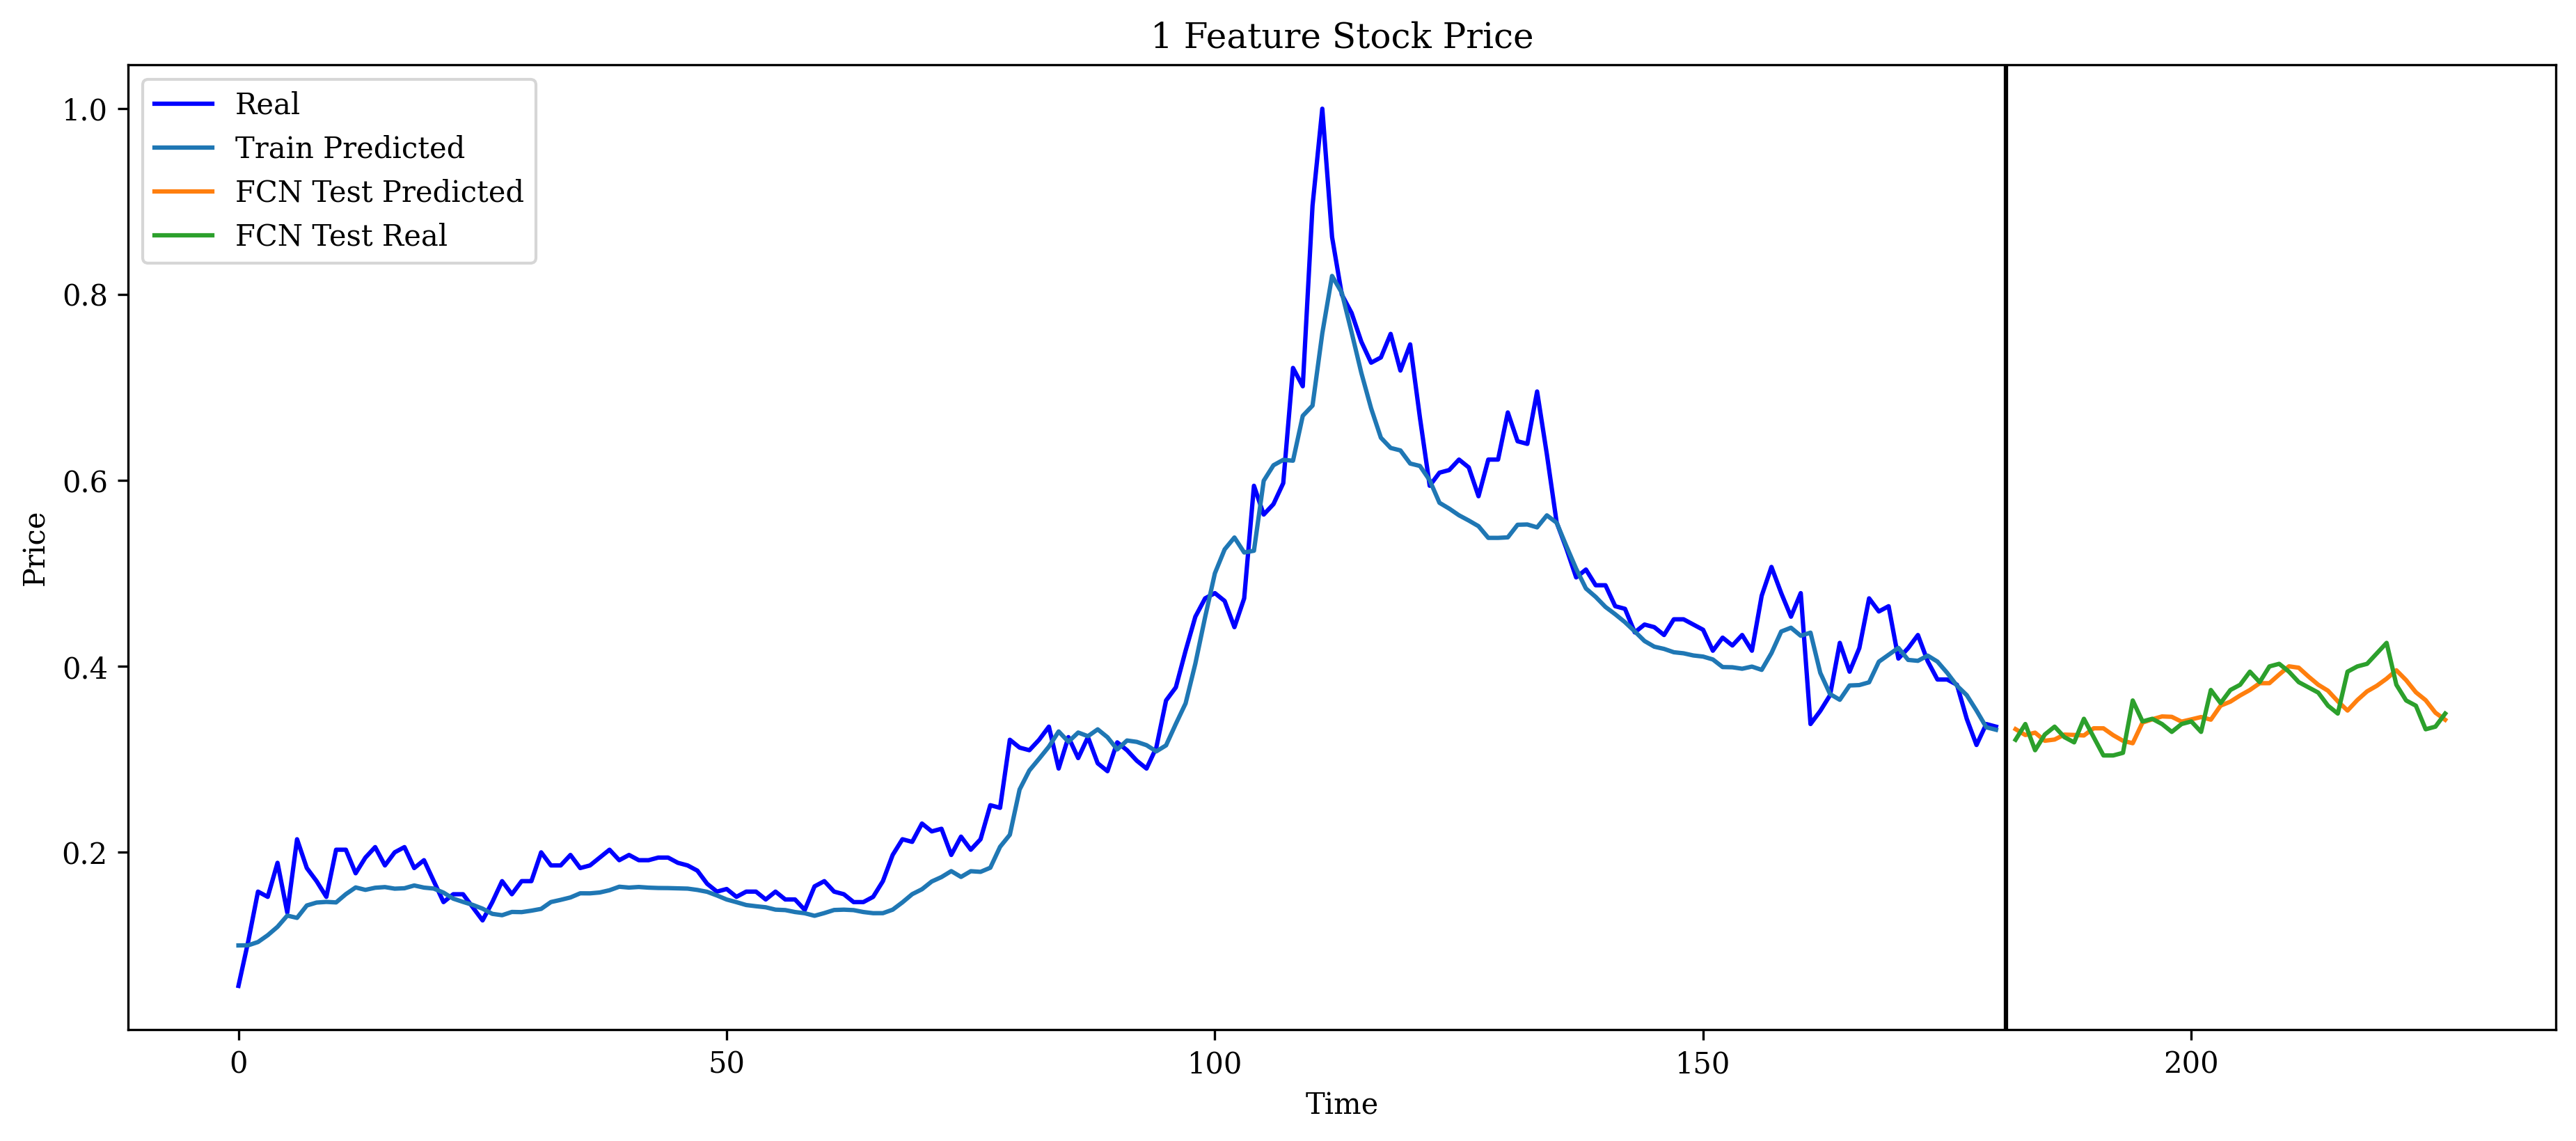

In [65]:
plt.rcParams['font.family']='serif'
plt.figure(figsize=(15,6),dpi=300)
plt.title('1 Feature Stock Price')
plt.plot(range(len(real_y_1)),real_y_1,color='blue',label='Real')
plt.plot(range(len(list1)),list1,label='Train Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),list2,label='FCN Test Predicted')
plt.plot(range(len(real_y_1)+1,len(real_y_1)+len(list2)+1),real_y_2,label='FCN Test Real')
# plt.plot(range(len(Y_train_p)+1,len(Y_train_p)+len(Yvalidation)+1),Yvalidation)
# plt.plot(validation.index,pd.DataFrame(LSTM_pred),color='red',label='LSTM Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.axvline(len(real_y_1),color='black')
plt.legend(loc = "upper left")
plt.savefig('./result/1 Feature Prediction.jpg')